# Part-3: The Battle of Neighborhoods

## Choosing the best residence based on neighboring amenities

<b>IBM Data Science Specialztion - Coursera</b><br>
Week 5 assignment

Md Ibtehajul Islam<br>
Email: iibtehajul@gmail.com<br>
LinkedIn: islam-md-ibtehajul<br>

## Importing libraries

In [238]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas.io.json import json_normalize

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
import xlrd

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')

print('Matplotlib version: ',mpl.__version__)

print('Folium installed')
print('Libraries imported.')

Matplotlib version:  3.0.3
Folium installed
Libraries imported.


### Defining Foursquare Credentials and Version

In [239]:
CLIENT_ID = '3ZUUVXNGIARZ1AEEBO1Y3OY3SKGRM3TKUNRMBXIVW3UK4415' # your Foursquare ID
CLIENT_SECRET = 'H2W3F5ZQYTT4EOY0ERCCATDMA1RC4E4W0BFTMWI5MGC0AWV2' # your Foursquare Secret
VERSION = '20180604'
LIMIT = 30

### Defining the centre location of interest 

In [240]:
address = '301 Front St W, Toronto, ON'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print(latitude, longitude)

43.6425637 -79.3870871832047


### Defining the category of interest near the location 

In [241]:
search_query = 'Apartment'
radius = 5000
print(search_query + ' .... OK!')

Apartment .... OK!


### Generating url and json map from Foursquare API

In [242]:
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude, VERSION, search_query, radius, LIMIT)
url

'https://api.foursquare.com/v2/venues/search?client_id=3ZUUVXNGIARZ1AEEBO1Y3OY3SKGRM3TKUNRMBXIVW3UK4415&client_secret=H2W3F5ZQYTT4EOY0ERCCATDMA1RC4E4W0BFTMWI5MGC0AWV2&ll=43.6425637,-79.3870871832047&v=20180604&query=Apartment&radius=5000&limit=30'

In [243]:
results = requests.get(url).json()
#results

### Finding all the venues around the selected location & structuring into a dataframe

In [244]:
# assign relevant part of JSON to venues
venues = results['response']['venues']

# tranform venues into a dataframe
dataframe = json_normalize(venues)
dataframe.head()

,categories,hasPerk,id,location.address,location.cc,location.city,location.country,location.crossStreet,location.distance,location.formattedAddress,location.labeledLatLngs,location.lat,location.lng,location.postalCode,location.state,name,referralId
0,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",False,4e040bb0b61c7592ae6e588b,16 willison sq,CA,Toronto,Canada,spandina AVe,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...","[{'label': 'display', 'lat': 43.65216840171611...",43.652168,-79.398821,M5T 1E8,ON,University Apartment,v-1564846882
1,[],False,5364e2f6498e2cafa29810aa,73 Richmond St. West,CA,Toronto,Canada,NaN,988,"[73 Richmond St. West, Toronto ON M5H 1Z4, Can...","[{'label': 'display', 'lat': 43.6508178710938,...",43.650818,-79.382559,M5H 1Z4,ON,Financial District Furnished Apartment,v-1564846882
2,"[{'id': '4bf58dd8d48988d1fa931735', 'name': 'H...",False,4ad4c05bf964a5209df520e3,77 Ryerson Ave,CA,Toronto,Canada,NaN,1507,"[77 Ryerson Ave, Toronto ON M5T 2V4, Canada]","[{'label': 'display', 'lat': 43.65006053050052...",43.650061,-79.402669,M5T 2V4,ON,Alexandra Apartment Hotel,v-1564846882
3,"[{'id': '4d954b06a243a5684965b473', 'name': 'R...",False,542cc75a498e68715daf6f88,822-65 Scadding Avenue,CA,Toronto,Canada,NaN,1926,"[822-65 Scadding Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.648552, 'lng':...",43.648552,-79.364645,NaN,ON,Mark's Downtown Apartment,v-1564846882
4,"[{'id': '4bf58dd8d48988d12a941735', 'name': 'C...",False,4fca7852e4b0c116823a6344,NaN,CA,NaN,Canada,NaN,2196,[Canada],"[{'label': 'display', 'lat': 43.66229767427558...",43.662298,-79.386956,NaN,NaN,Lieutenant-Governors Apartment - Queen's Park,v-1564846882


In [245]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered.head()

,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,University Apartment,Residential Building (Apartment / Condo),16 willison sq,CA,Toronto,Canada,spandina AVe,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...","[{'label': 'display', 'lat': 43.65216840171611...",43.652168,-79.398821,M5T 1E8,ON,4e040bb0b61c7592ae6e588b
1,Financial District Furnished Apartment,None,73 Richmond St. West,CA,Toronto,Canada,NaN,988,"[73 Richmond St. West, Toronto ON M5H 1Z4, Can...","[{'label': 'display', 'lat': 43.6508178710938,...",43.650818,-79.382559,M5H 1Z4,ON,5364e2f6498e2cafa29810aa
2,Alexandra Apartment Hotel,Hotel,77 Ryerson Ave,CA,Toronto,Canada,NaN,1507,"[77 Ryerson Ave, Toronto ON M5T 2V4, Canada]","[{'label': 'display', 'lat': 43.65006053050052...",43.650061,-79.402669,M5T 2V4,ON,4ad4c05bf964a5209df520e3
3,Mark's Downtown Apartment,Residential Building (Apartment / Condo),822-65 Scadding Avenue,CA,Toronto,Canada,NaN,1926,"[822-65 Scadding Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.648552, 'lng':...",43.648552,-79.364645,NaN,ON,542cc75a498e68715daf6f88
4,Lieutenant-Governors Apartment - Queen's Park,Capitol Building,NaN,CA,NaN,Canada,NaN,2196,[Canada],"[{'label': 'display', 'lat': 43.66229767427558...",43.662298,-79.386956,NaN,NaN,4fca7852e4b0c116823a6344


In [246]:
df =dataframe_filtered 

### Keepking only the residencial venues

In [247]:
new_df = df[(df.categories == 'Residence') | (df.categories == 'Assisted Living') | (df.categories == 'Home (private)') | (df.categories == 'Housing Development') | (df.categories == 'Residential Building (Apartment / Condo)')]

In [248]:
print('Data frame shape: {}'.format(new_df.shape))

Data frame shape: (18, 15)


### Data wrangling

In [249]:
print(new_df.shape)
new_df.head()

(18, 15)


,name,categories,address,cc,city,country,crossStreet,distance,formattedAddress,labeledLatLngs,lat,lng,postalCode,state,id
0,University Apartment,Residential Building (Apartment / Condo),16 willison sq,CA,Toronto,Canada,spandina AVe,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...","[{'label': 'display', 'lat': 43.65216840171611...",43.652168,-79.398821,M5T 1E8,ON,4e040bb0b61c7592ae6e588b
3,Mark's Downtown Apartment,Residential Building (Apartment / Condo),822-65 Scadding Avenue,CA,Toronto,Canada,NaN,1926,"[822-65 Scadding Avenue, Toronto ON, Canada]","[{'label': 'display', 'lat': 43.648552, 'lng':...",43.648552,-79.364645,NaN,ON,542cc75a498e68715daf6f88
5,Ahil's Apartment,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,2691,[Canada],"[{'label': 'display', 'lat': 43.66392238830782...",43.663922,-79.402740,NaN,NaN,5633e92b498ea61bed39e5a8
7,Alen's Apartment,Residential Building (Apartment / Condo),NaN,CA,NaN,Canada,NaN,2960,[Canada],"[{'label': 'display', 'lat': 43.642075, 'lng':...",43.642075,-79.423836,NaN,NaN,587258da1b36d47bd132a190
8,Dufferin Park Apartment,Residential Building (Apartment / Condo),919 Dufferin Street,CA,Toronto,Canada,NaN,4127,"[919 Dufferin Street, Toronto ON M6H 4B3, Canada]","[{'label': 'display', 'lat': 43.65728286810229...",43.657283,-79.434124,M6H 4B3,ON,515e285ce4b0510b074acdff


In [250]:
new_df.drop(['categories', 'cc', 'city', 'country', 'crossStreet', 'labeledLatLngs','state','id'], axis = 1, inplace = True)
new_df.rename(columns={'name':'Apt_Name', 'address':'Address', 'distance':'Distance', 'formattedAddress':'Formatted_Address',\
                      'lat':'Latitude', 'lng':'Longitude', 'postalCode':'Postalcode'}, inplace=True)

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [251]:
new_df = new_df.dropna()
new_df.sort_values(by=['Distance'], axis=0, ascending=True, inplace=True)

In [252]:
new_df = new_df.reset_index(drop=True)
new_df.head()

,Apt_Name,Address,Distance,Formatted_Address,Latitude,Longitude,Postalcode
0,University Apartment,16 willison sq,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...",43.652168,-79.398821,M5T 1E8
1,Elm Place Apartments,222 Elm St.,1576,"[222 Elm St. (Elm & Mccaul), Toronto ON M5T 1K...",43.656243,-79.392139,M5T 1K5
2,1 Homewood Ave Apartments,1 Homewood Ave,2514,"[1 Homewood Ave (Carlton St), Toronto ON M4Y 2...",43.663222,-79.374450,M4Y 2J7
3,Allan Plaza Apartments,166 Carlton Street,2568,"[166 Carlton Street, Toronto ON M5A 2K5, Canada]",43.663463,-79.373573,M5A 2K5
4,Cromwell Apartments,55 Isabella Street,2869,"[55 Isabella Street, Toronto ON M4Y 1M8, Canada]",43.668187,-79.383245,M4Y 1M8


In [253]:
new_df['Postalcode'] =  new_df['Postalcode'].str.split(' ').apply(pd.Series)\
    .merge(new_df, left_index = True, right_index = True)\
    .drop(["Postalcode", 1], axis = 1)
new_df.head()

,Apt_Name,Address,Distance,Formatted_Address,Latitude,Longitude,Postalcode
0,University Apartment,16 willison sq,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...",43.652168,-79.398821,M5T
1,Elm Place Apartments,222 Elm St.,1576,"[222 Elm St. (Elm & Mccaul), Toronto ON M5T 1K...",43.656243,-79.392139,M5T
2,1 Homewood Ave Apartments,1 Homewood Ave,2514,"[1 Homewood Ave (Carlton St), Toronto ON M4Y 2...",43.663222,-79.374450,M4Y
3,Allan Plaza Apartments,166 Carlton Street,2568,"[166 Carlton Street, Toronto ON M5A 2K5, Canada]",43.663463,-79.373573,M5A
4,Cromwell Apartments,55 Isabella Street,2869,"[55 Isabella Street, Toronto ON M4Y 1M8, Canada]",43.668187,-79.383245,M4Y


### Adding and merging the Toronto(Postal code and Borough) data with residential venue data

## Extracting the dataset from the wikipidea link: 

In [254]:
'''
wikipedia_link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
wikipedia_page = requests.get(wikipedia_link)
page= wikipedia_page.text
'''

"\nwikipedia_link = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'\nwikipedia_page = requests.get(wikipedia_link)\npage= wikipedia_page.text\n"

## Scraping the HTML
The data we want is in a table, with 3 columns PostalCode, Borough and Neighborhood.<br>
The table contains a list of postal codes in Canada where the first letter is M. Postal codes beginning with M are located within the city of Toronto in the province of Ontario. Only the first three characters are listed, corresponding to the Forward Sortation Area.

In [255]:
'''
soup = BeautifulSoup(page, 'html.parser')
match = soup.find_all('tr')
results= match[1:-5]
results[-1]
results[0].contents[5].text[0:-1]

records = []
for result in results:
    postalcode = result.contents[1].text
    borough = result.contents[3].text
    neighbourhood = result.contents[5].text[0:-1]
    records.append((postalcode, borough, neighbourhood))
    
df = pd.DataFrame(records, columns=['Postalcode', 'Borough', 'Neighbourhood'])
df.to_csv('List of postal codes of Canada.csv', index=False)

'''

"\nsoup = BeautifulSoup(page, 'html.parser')\nmatch = soup.find_all('tr')\nresults= match[1:-5]\nresults[-1]\nresults[0].contents[5].text[0:-1]\n\nrecords = []\nfor result in results:\n    postalcode = result.contents[1].text\n    borough = result.contents[3].text\n    neighbourhood = result.contents[5].text[0:-1]\n    records.append((postalcode, borough, neighbourhood))\n    \ndf = pd.DataFrame(records, columns=['Postalcode', 'Borough', 'Neighbourhood'])\ndf.to_csv('List of postal codes of Canada.csv', index=False)\n\n"

## Finding the all the boroughs for the residential venues

In [256]:
df_lat_long = pd.read_csv('List of postal codes of Canada_with_latlong.csv')
df_lat_long.head()

,Postalcode,Borough,Neighbourhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge, Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek, Rouge Hill, Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood, Morningside, West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [257]:
df_lat_long = pd.read_csv('List of postal codes of Canada_with_latlong.csv')
df_lat_long_P = df_lat_long.drop(['Neighbourhood', 'Latitude', 'Longitude'], axis = 1)
print(df_lat_long_P.shape)
df_lat_long_P.head()

(103, 2)


,Postalcode,Borough
0,M1B,Scarborough
1,M1C,Scarborough
2,M1E,Scarborough
3,M1G,Scarborough
4,M1H,Scarborough


In [258]:
df_final = pd.merge(new_df, df_lat_long_P, on = 'Postalcode')

In [259]:
print(df_final['Borough'].unique())

['Downtown Toronto' 'West Toronto' 'Central Toronto']


In [305]:
df_final

,Apt_Name,Address,Distance,Formatted_Address,Latitude,Longitude,Postalcode,Borough
0,University Apartment,16 willison sq,1427,"[16 willison sq (spandina AVe), Toronto ON M5T...",43.652168,-79.398821,M5T,Downtown Toronto
1,Elm Place Apartments,222 Elm St.,1576,"[222 Elm St. (Elm & Mccaul), Toronto ON M5T 1K...",43.656243,-79.392139,M5T,Downtown Toronto
2,1 Homewood Ave Apartments,1 Homewood Ave,2514,"[1 Homewood Ave (Carlton St), Toronto ON M4Y 2...",43.663222,-79.374450,M4Y,Downtown Toronto
3,Cromwell Apartments,55 Isabella Street,2869,"[55 Isabella Street, Toronto ON M4Y 1M8, Canada]",43.668187,-79.383245,M4Y,Downtown Toronto
4,CAPREIT Toronto Apartments - 100 Wellesley St ...,100 Wellesley Street East,2965,[100 Wellesley Street East (Church and Wellesl...,43.667856,-79.375513,M4Y,Downtown Toronto
5,Allan Plaza Apartments,166 Carlton Street,2568,"[166 Carlton Street, Toronto ON M5A 2K5, Canada]",43.663463,-79.373573,M5A,Downtown Toronto
6,RodXtein Apartment,650 Parliament Street,3262,"[650 Parliament Street (Wellesley), Toronto ON...",43.669737,-79.371923,M4X,Downtown Toronto
7,Dufferin Park Apartment,919 Dufferin Street,4127,"[919 Dufferin Street, Toronto ON M6H 4B3, Canada]",43.657283,-79.434124,M6H,West Toronto
8,St. Edmund Apartments,7 Edmund Ave.,4596,"[7 Edmund Ave. (Avenue Rd.), Toronto ON M4V 1E...",43.682649,-79.400770,M4V,Central Toronto
9,Bunker Apartment,630 St Clair av W,5289,"[630 St Clair av W, Toronto ON M6G 2Y2, Canada]",43.681970,-79.423780,M6G,Downtown Toronto


# Exploratory data analysis:

### Analyzing the distances of the apartments from the center of location

In [261]:
new_df_dis = new_df[['Apt_Name', 'Distance']]
new_df_dis.set_index('Apt_Name', inplace = True)
#new_df_dis.head()

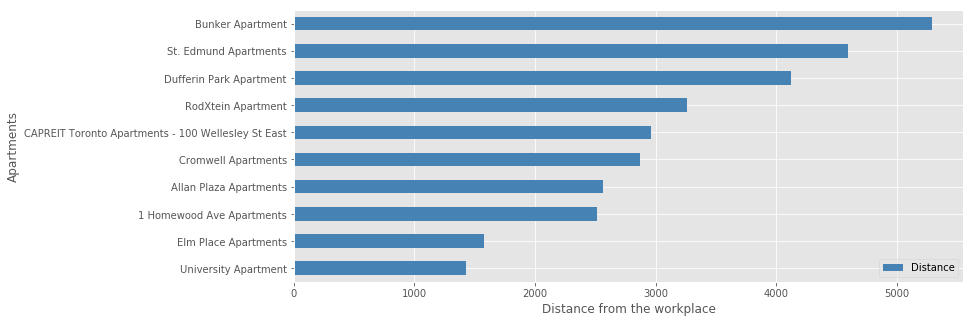

In [262]:
# plotting the bar graph 
new_df_dis.plot(kind = 'barh', figsize = (12,5), color= 'steelblue')
plt.xlabel('Distance from the workplace')
plt.ylabel('Apartments')

plt.show()

### Finding all the neighbourhoos in those Boroughs in Toronto

In [263]:
toronto_borough = ['Downtown Toronto', 'West Toronto']
toronto_df = df_lat_long[df_lat_long['Borough'].isin(toronto_borough)].reset_index(drop = True)
print(toronto_df.shape)
#toronto_df.head()

(24, 5)


In [264]:
print('The dataframe has {} boroughs and {} neighbourhoods.'.format(
        len(toronto_df['Borough'].unique()),
        toronto_df.shape[0]
    )
)

The dataframe has 2 boroughs and 24 neighbourhoods.


### Creating a map of Toronto city with neighborhoods with found Boroughs, superimposed on top using Folium

### Using analysis based on the apartments

In [265]:
map_new_toronto = folium.Map(location=[latitude, longitude], zoom_start=13)

# add a red circle marker to represent the workplace
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Location of interest',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_new_toronto)

# add markers to map
for lat, lng, borough, postalcode in zip(df_final['Latitude'], df_final['Longitude'], df_final['Borough'], df_final['Postalcode']):
    label = '{}, {}'.format(borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_toronto)  
    
map_new_toronto


#### Using analysis based on neighbourhoods

In [266]:
map_new_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add a red circle marker to represent the workplace
folium.CircleMarker(
    [latitude, longitude],
    radius=10,
    color='red',
    popup='Location of interest',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(map_new_toronto)

# add markers to map
for lat, lng, borough, neighbourhood, postalcode in zip(toronto_df['Latitude'], toronto_df['Longitude'], toronto_df['Borough'], toronto_df['Neighbourhood'], toronto_df['Postalcode']):
    label = '{}, {}, {}'.format(neighbourhood, borough, postalcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_new_toronto)  
    
map_new_toronto

### Getting nearby venues around the residencial places

In [267]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Apt. Name', 
                  'Apt. Latitude', 
                  'Apt. Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  Creating a new dataframe called *Toronto_venues* by runnig the above function on it's each residencial places

In [268]:
toronto_venues = getNearbyVenues(names=df_final['Apt_Name'],
                                   latitudes=df_final['Latitude'],
                                   longitudes=df_final['Longitude'],
                                   radius=500
                                  )

University Apartment
Elm Place Apartments
1 Homewood Ave Apartments
Cromwell Apartments
CAPREIT Toronto Apartments - 100 Wellesley St East
Allan Plaza Apartments
RodXtein Apartment
Dufferin Park Apartment
St. Edmund Apartments
Bunker Apartment


#### Checking the size of the resulting dataframe

In [269]:
print(toronto_venues.shape)
toronto_venues.head()

(562, 7)


,Apt. Name,Apt. Latitude,Apt. Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,University Apartment,43.652168,-79.398821,Sonic Boom,43.650859,-79.396985,Record Shop
1,University Apartment,43.652168,-79.398821,El Rey,43.652764,-79.400048,Cocktail Bar
2,University Apartment,43.652168,-79.398821,Maker Pizza,43.650401,-79.398040,Pizza Place
3,University Apartment,43.652168,-79.398821,FIKA Cafe,43.653560,-79.400402,Café
4,University Apartment,43.652168,-79.398821,Banh Mi Nguyen Huong,43.653628,-79.398376,Vietnamese Restaurant


#### Checking how many venues were returned for each neighborhood


In [270]:
toronto_venues.groupby(['Apt. Name', ]).count()

,Apt. Latitude,Apt. Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Apt. Name,,,,,,
1 Homewood Ave Apartments,51,51,51,51,51,51
Allan Plaza Apartments,58,58,58,58,58,58
Bunker Apartment,54,54,54,54,54,54
CAPREIT Toronto Apartments - 100 Wellesley St East,45,45,45,45,45,45
Cromwell Apartments,100,100,100,100,100,100
Dufferin Park Apartment,39,39,39,39,39,39
Elm Place Apartments,76,76,76,76,76,76
RodXtein Apartment,33,33,33,33,33,33
St. Edmund Apartments,6,6,6,6,6,6


#### Finding out the number of unique categories can be curated from all the returned venues

In [271]:
print('There are {} uniques categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 151 uniques categories.


## Analyzing Each Residencial places

In [272]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Apt. Name'] = toronto_venues['Apt. Name'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Apt. Name,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,University Apartment,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [273]:
print('The data frame size is {}'.format(toronto_onehot.shape))

The data frame size is (562, 152)


#### Next, grouping rows by Residencial places and by taking the mean of the frequency of occurrence of each category

In [274]:
toronto_apt_grouped = toronto_onehot.groupby('Apt. Name').mean().reset_index()
toronto_apt_grouped.head()

,Apt. Name,Adult Boutique,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,...,Udon Restaurant,University,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Yoga Studio
0,1 Homewood Ave Apartments,0.00,0.00,0.0,0.019608,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.00,0.00
1,Allan Plaza Apartments,0.00,0.00,0.0,0.017241,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.00,0.00
2,Bunker Apartment,0.00,0.00,0.0,0.000000,0.0,0.018519,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.000000,0.00,0.00
3,CAPREIT Toronto Apartments - 100 Wellesley St ...,0.00,0.00,0.0,0.022222,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.022222,0.00,0.00
4,Cromwell Apartments,0.01,0.01,0.0,0.010000,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.01,0.01,0.01,0.0,0.010000,0.01,0.02


In [275]:
print('The new data frame size is {}'.format(toronto_apt_grouped.shape))

The new data frame size is (10, 152)


#### Printing each residencial place along with the top 5 most common venues

In [276]:
num_apt_top_venues = 10

for hood in toronto_apt_grouped['Apt. Name']:
    print("----"+hood+"----")
    temp = toronto_apt_grouped[toronto_apt_grouped['Apt. Name'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----1 Homewood Ave Apartments----
                  venue  freq
0   Japanese Restaurant  0.08
1           Coffee Shop  0.06
2               Gay Bar  0.06
3      Ramen Restaurant  0.04
4  Fast Food Restaurant  0.04
5                 Diner  0.04
6             Gastropub  0.04
7                 Hotel  0.04
8         Grocery Store  0.04
9    Falafel Restaurant  0.02


----Allan Plaza Apartments----
                  venue  freq
0           Coffee Shop  0.09
1            Restaurant  0.05
2             Gastropub  0.05
3   Japanese Restaurant  0.03
4                 Hotel  0.03
5  Fast Food Restaurant  0.03
6                   Pub  0.03
7                 Diner  0.03
8         Grocery Store  0.03
9            Playground  0.02


----Bunker Apartment----
                  venue  freq
0           Coffee Shop  0.11
1                Bakery  0.06
2    Italian Restaurant  0.06
3        Ice Cream Shop  0.06
4  Fast Food Restaurant  0.04
5                  Café  0.04
6            Restaurant  0.04
7     

#### Putting that into a *pandas* dataframe by write a function to sort the venues in descending order.

In [277]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating the new dataframe and display the top 10 venues for each Residential building.

In [295]:
num_apt_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Apt. Name']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_apt_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_apt_venues_sorted['Apt. Name'] = toronto_apt_grouped['Apt. Name']

for ind in np.arange(toronto_apt_grouped.shape[0]):
    neighbourhoods_apt_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_apt_grouped.iloc[ind, :], num_apt_top_venues)

#neighbourhoods_venues_sorted.set_index('Apt. Name', inplace = True)    
#neighbourhoods_apt_venues_sorted.to_csv("neighbourhoods_venues_sorted.csv")
neighbourhoods_apt_venues_sorted


,Apt. Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Homewood Ave Apartments,Japanese Restaurant,Coffee Shop,Gay Bar,Diner,Gastropub,Grocery Store,Hotel,Fast Food Restaurant,Ramen Restaurant,Pet Store
1,Allan Plaza Apartments,Coffee Shop,Gastropub,Restaurant,Diner,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Hotel,Pub,Garden
2,Bunker Apartment,Coffee Shop,Italian Restaurant,Ice Cream Shop,Bakery,Fast Food Restaurant,Pizza Place,Café,Intersection,Indian Restaurant,Restaurant
3,CAPREIT Toronto Apartments - 100 Wellesley St ...,Coffee Shop,Grocery Store,Dance Studio,Pizza Place,Breakfast Spot,Caribbean Restaurant,Park,Smoothie Shop,Steakhouse,Wine Shop
4,Cromwell Apartments,Coffee Shop,Sushi Restaurant,Café,Japanese Restaurant,Restaurant,Burger Joint,Yoga Studio,Indian Restaurant,Gay Bar,Gym
5,Dufferin Park Apartment,Bakery,Coffee Shop,Bar,Restaurant,Cocktail Bar,Clothing Store,Park,Beer Store,Beer Bar,Mexican Restaurant
6,Elm Place Apartments,Coffee Shop,Sandwich Place,Café,Chinese Restaurant,Sushi Restaurant,Japanese Restaurant,Ice Cream Shop,Arts & Crafts Store,Ramen Restaurant,Art Gallery
7,RodXtein Apartment,Coffee Shop,Pizza Place,Café,Grocery Store,Hotel,Bistro,Playground,Diner,Dive Bar,Park
8,St. Edmund Apartments,Park,Supermarket,French Restaurant,Liquor Store,Light Rail Station,Fast Food Restaurant,Farmers Market,Falafel Restaurant,Event Space,Ethiopian Restaurant
9,University Apartment,Bar,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Dessert Shop,Vietnamese Restaurant,Mexican Restaurant,Dumpling Restaurant,Burger Joint,Grocery Store


### Creating the new dataframe and display the top 10 venues for each Neighborhoods.

In [279]:
def getNearbyVenues(names, latitudes, longitudes, radius=500, LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

####  Creating a new dataframe called *toronto_neighbourhood_venues* by runnig the above function on it's each neighborhood

In [280]:
toronto_neighbourhood_venues = getNearbyVenues(names=toronto_df['Neighbourhood'],
                                   latitudes=toronto_df['Latitude'],
                                   longitudes=toronto_df['Longitude'],
                                   radius=500
                                  )

Rosedale
Cabbagetown, St. James Town
Church and Wellesley
Harbourfront, Regent Park
Ryerson, Garden District
St. James Town
Berczy Park
Central Bay Street
Adelaide, King, Richmond
Harbourfront East, Toronto Islands, Union Station
Design Exchange, Toronto Dominion Centre
Commerce Court, Victoria Hotel
Harbord, University of Toronto
Chinatown, Grange Park, Kensington Market
CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara
Stn A PO Boxes 25 The Esplanade
First Canadian Place, Underground city
Christie
Dovercourt Village, Dufferin
Little Portugal, Trinity
Brockton, Exhibition Place, Parkdale Village
High Park, The Junction South
Parkdale, Roncesvalles
Runnymede, Swansea


In [304]:
print(toronto_neighbourhood_venues.shape)
print(toronto_neighbourhood_venues['Neighbourhood'].unique())
toronto_neighbourhood_venues.head()

(1460, 7)
['Rosedale' 'Cabbagetown, St. James Town' 'Church and Wellesley'
 'Harbourfront, Regent Park' 'Ryerson, Garden District' 'St. James Town'
 'Berczy Park' 'Central Bay Street' 'Adelaide, King, Richmond'
 'Harbourfront East, Toronto Islands, Union Station'
 'Design Exchange, Toronto Dominion Centre'
 'Commerce Court, Victoria Hotel' 'Harbord, University of Toronto'
 'Chinatown, Grange Park, Kensington Market'
 'CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara'
 'Stn A PO Boxes 25 The Esplanade'
 'First Canadian Place, Underground city' 'Christie'
 'Dovercourt Village, Dufferin' 'Little Portugal, Trinity'
 'Brockton, Exhibition Place, Parkdale Village'
 'High Park, The Junction South' 'Parkdale, Roncesvalles'
 'Runnymede, Swansea']


,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Rosedale,43.679563,-79.377529,Mooredale House,43.678631,-79.380091,Building
1,Rosedale,43.679563,-79.377529,Rosedale Park,43.682328,-79.378934,Playground
2,Rosedale,43.679563,-79.377529,Whitney Park,43.682036,-79.373788,Park
3,Rosedale,43.679563,-79.377529,Alex Murray Parkette,43.678300,-79.382773,Park
4,Rosedale,43.679563,-79.377529,Milkman's Lane,43.676352,-79.373842,Trail


#### checking how many venues were returned for each neighborhood

In [282]:
toronto_neighbourhood_venues.groupby(['Neighbourhood', ]).count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
"Adelaide, King, Richmond",100,100,100,100,100,100
Berczy Park,55,55,55,55,55,55
"Brockton, Exhibition Place, Parkdale Village",23,23,23,23,23,23
"CN Tower, Bathurst Quay, Island airport, Harbourfront West, King and Spadina, Railway Lands, South Niagara",17,17,17,17,17,17
"Cabbagetown, St. James Town",47,47,47,47,47,47
Central Bay Street,81,81,81,81,81,81
"Chinatown, Grange Park, Kensington Market",100,100,100,100,100,100
Christie,16,16,16,16,16,16
Church and Wellesley,85,85,85,85,85,85


#### Finding out the number of unique categories can be curated from all the returned venues

In [283]:
print('There are {} uniques categories.'.format(len(toronto_neighbourhood_venues['Venue Category'].unique())))

There are 221 uniques categories.


## Analyzing Each Neighborhood

In [284]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_neighbourhood_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighbourhood column back to dataframe
toronto_onehot['Neighbourhood'] = toronto_neighbourhood_venues['Neighbourhood'] 

# move neighbourhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,Rosedale,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [285]:
print('The data frame size is {}'.format(toronto_onehot.shape))

The data frame size is (1460, 222)


#### Next, grouping rows by neighbourhood and by taking the mean of the frequency of occurrence of each category

In [286]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,Airport Food Court,Airport Gate,Airport Lounge,Airport Service,Airport Terminal,American Restaurant,Antique Shop,...,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Vietnamese Restaurant,Wine Bar,Wings Joint,Yoga Studio
0,"Adelaide, King, Richmond",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.030000,0.0,...,0.0,0.0,0.0,0.0,0.010000,0.0,0.0,0.01,0.0,0.0
1,Berczy Park,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.018182,0.0,0.0,0.00,0.0,0.0
2,"Brockton, Exhibition Place, Parkdale Village",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",0.0,0.058824,0.058824,0.058824,0.117647,0.176471,0.117647,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0
4,"Cabbagetown, St. James Town",0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.021277,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00,0.0,0.0


In [287]:
print('The new data frame size is {}'.format(toronto_grouped.shape))

The new data frame size is (24, 222)


#### Printing each neighborhood along with the top 10 most common venues

In [288]:
num_top_venues = 10

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Adelaide, King, Richmond----
              venue  freq
0       Coffee Shop  0.07
1              Café  0.05
2               Bar  0.04
3   Thai Restaurant  0.04
4        Steakhouse  0.04
5    Breakfast Spot  0.03
6      Burger Joint  0.03
7  Asian Restaurant  0.03
8        Restaurant  0.03
9               Gym  0.03


----Berczy Park----
                venue  freq
0         Coffee Shop  0.09
1        Cocktail Bar  0.05
2              Bakery  0.05
3          Steakhouse  0.04
4                Café  0.04
5         Cheese Shop  0.04
6  Seafood Restaurant  0.04
7            Beer Bar  0.04
8      Farmers Market  0.04
9               Diner  0.02


----Brockton, Exhibition Place, Parkdale Village----
                    venue  freq
0          Breakfast Spot  0.09
1                    Café  0.09
2             Coffee Shop  0.09
3                     Bar  0.04
4              Restaurant  0.04
5               Pet Store  0.04
6    Caribbean Restaurant  0.04
7      Falafel Restaurant  0.04
8       

9                Pizza Place  0.02


----St. James Town----
                venue  freq
0         Coffee Shop  0.07
1                Café  0.05
2  Italian Restaurant  0.05
3          Restaurant  0.05
4               Hotel  0.04
5      Clothing Store  0.03
6            Beer Bar  0.03
7           Gastropub  0.03
8      Cosmetics Shop  0.03
9        Cocktail Bar  0.03


----Stn A PO Boxes 25 The Esplanade----
                  venue  freq
0           Coffee Shop  0.11
1                  Café  0.04
2            Restaurant  0.04
3                Bakery  0.03
4              Beer Bar  0.03
5                 Hotel  0.03
6          Cocktail Bar  0.03
7    Seafood Restaurant  0.03
8  Fast Food Restaurant  0.03
9                Lounge  0.02




#### Putting that into a *pandas* dataframe by write a function to sort the venues in descending order.

In [289]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Creating the new dataframe and display the top 10 venues for each neighborhood.

In [290]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"Adelaide, King, Richmond",Coffee Shop,Café,Bar,Thai Restaurant,Steakhouse,Cosmetics Shop,Asian Restaurant,Gym,Burger Joint,Hotel
1,Berczy Park,Coffee Shop,Cocktail Bar,Bakery,Steakhouse,Cheese Shop,Café,Farmers Market,Beer Bar,Seafood Restaurant,Breakfast Spot
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Grocery Store,Intersection,Falafel Restaurant,Convenience Store,Burrito Place,Restaurant,Stadium
3,"CN Tower, Bathurst Quay, Island airport, Harbo...",Airport Service,Airport Lounge,Airport Terminal,Boutique,Airport,Airport Food Court,Airport Gate,Sculpture Garden,Bar,Boat or Ferry
4,"Cabbagetown, St. James Town",Coffee Shop,Restaurant,Café,Pub,Italian Restaurant,Pizza Place,Bakery,Market,Outdoor Sculpture,Butcher


# Inquiring for a specific venue of choice for comparing the residential places or neighbourhoods

#### Checkig all the unique common venues

In [291]:
'''
print('All of the 1st Most Common Venues: {}'.format(neighbourhoods_venues_sorted['1st Most Common Venue'].unique()))
print()
print('All of the 2nd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['2nd Most Common Venue'].unique()))
print()
print('All of the 3rd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['3rd Most Common Venue'].unique()))
print()
print('All of the 4th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['4th Most Common Venue'].unique()))
print()
print('All of the 5th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['5th Most Common Venue'].unique()))
print()
'''

"\nprint('All of the 1st Most Common Venues: {}'.format(neighbourhoods_venues_sorted['1st Most Common Venue'].unique()))\nprint()\nprint('All of the 2nd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['2nd Most Common Venue'].unique()))\nprint()\nprint('All of the 3rd Most Common Venues: {}'.format(neighbourhoods_venues_sorted['3rd Most Common Venue'].unique()))\nprint()\nprint('All of the 4th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['4th Most Common Venue'].unique()))\nprint()\nprint('All of the 5th Most Common Venues: {}'.format(neighbourhoods_venues_sorted['5th Most Common Venue'].unique()))\nprint()\n"

In [297]:
pd.unique(neighbourhoods_venues_sorted[['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue',
       '10th Most Common Venue', '10th Most Common Venue']].values.ravel('K'))

array(['Coffee Shop', 'Café', 'Bar', 'Thai Restaurant', 'Steakhouse',
       'Cosmetics Shop', 'Asian Restaurant', 'Gym', 'Burger Joint',
       'Hotel', 'Cocktail Bar', 'Bakery', 'Cheese Shop', 'Farmers Market',
       'Beer Bar', 'Seafood Restaurant', 'Breakfast Spot',
       'Grocery Store', 'Intersection', 'Falafel Restaurant',
       'Convenience Store', 'Burrito Place', 'Restaurant', 'Stadium',
       'Airport Service', 'Airport Lounge', 'Airport Terminal',
       'Boutique', 'Airport', 'Airport Food Court', 'Airport Gate',
       'Sculpture Garden', 'Boat or Ferry', 'Pub', 'Italian Restaurant',
       'Pizza Place', 'Market', 'Outdoor Sculpture', 'Butcher',
       'Ice Cream Shop', 'Sandwich Place', 'Chinese Restaurant',
       'Salad Place', 'Bubble Tea Shop', 'Spa',
       'Vegetarian / Vegan Restaurant', 'Mexican Restaurant',
       'Vietnamese Restaurant', 'Dumpling Restaurant', 'Gaming Cafe',
       'Park', 'Nightclub', 'Athletics & Sports', 'Diner', 'Baby Store',
       'J

## Inquiring for a specific amenities among neighborhoods

In [293]:
inquiry = 'Grocery Store'
neighbourhoods_venues_sorted[neighbourhoods_venues_sorted['Neighbourhood'].notnull() 
                            &(neighbourhoods_venues_sorted['1st Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['2nd Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['3rd Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['4th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['5th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['6th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['7th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['8th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['9th Most Common Venue'] == inquiry)
                            |(neighbourhoods_venues_sorted['10th Most Common Venue'] == inquiry)
                             
                            ]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,"Brockton, Exhibition Place, Parkdale Village",Breakfast Spot,Café,Coffee Shop,Grocery Store,Intersection,Falafel Restaurant,Convenience Store,Burrito Place,Restaurant,Stadium
7,Christie,Grocery Store,Café,Park,Nightclub,Athletics & Sports,Diner,Restaurant,Baby Store,Italian Restaurant,Coffee Shop
16,"High Park, The Junction South",Mexican Restaurant,Café,Bar,Grocery Store,Furniture / Home Store,Fast Food Restaurant,Bookstore,Flea Market,Cajun / Creole Restaurant,Speakeasy


## Inquiring for a specific amenities for residential buildings

In [296]:
inquiry = 'Grocery Store'
neighbourhoods_apt_venues_sorted[neighbourhoods_apt_venues_sorted['Apt. Name'].notnull() 
                            &(neighbourhoods_apt_venues_sorted['1st Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['2nd Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['3rd Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['4th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['5th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['6th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['7th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['8th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['9th Most Common Venue'] == inquiry)
                            |(neighbourhoods_apt_venues_sorted['10th Most Common Venue'] == inquiry)
                             
                            ]

,Apt. Name,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1 Homewood Ave Apartments,Japanese Restaurant,Coffee Shop,Gay Bar,Diner,Gastropub,Grocery Store,Hotel,Fast Food Restaurant,Ramen Restaurant,Pet Store
1,Allan Plaza Apartments,Coffee Shop,Gastropub,Restaurant,Diner,Grocery Store,Japanese Restaurant,Fast Food Restaurant,Hotel,Pub,Garden
3,CAPREIT Toronto Apartments - 100 Wellesley St ...,Coffee Shop,Grocery Store,Dance Studio,Pizza Place,Breakfast Spot,Caribbean Restaurant,Park,Smoothie Shop,Steakhouse,Wine Shop
7,RodXtein Apartment,Coffee Shop,Pizza Place,Café,Grocery Store,Hotel,Bistro,Playground,Diner,Dive Bar,Park
9,University Apartment,Bar,Café,Vegetarian / Vegan Restaurant,Chinese Restaurant,Dessert Shop,Vietnamese Restaurant,Mexican Restaurant,Dumpling Restaurant,Burger Joint,Grocery Store
